In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import os

print("Step 1: Imports done")


Step 1: Imports done


In [2]:
data_dir = r"C:\Users\aparn\Downloads\deepweed"
image_dir = os.path.join(data_dir, "images")
labels_csv = os.path.join(data_dir, "labels", "labels.csv")

epochs = 2
batch_size = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Step 2: Using device:", device)


Step 2: Using device: cpu


In [3]:
df = pd.read_csv(labels_csv)

class_names = sorted(df["Species"].unique())
label_map = {name: idx for idx, name in enumerate(class_names)}

df["label_idx"] = df["Species"].map(label_map)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label_idx"]
)

print("Step 3: Train/Test split done")
print("Classes:", class_names)


Step 3: Train/Test split done
Classes: ['Chinee apple', 'Lantana', 'Negative', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed']


In [4]:
class DeepWeedsDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.loc[idx, "Filename"]
        label = self.data.loc[idx, "label_idx"]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

print("Step 4: Transforms ready")


Step 4: Transforms ready


In [6]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

print("Step 4: Transforms ready")


Step 4: Transforms ready


In [7]:
train_dataset = DeepWeedsDataset(train_df, image_dir, train_tf)
test_dataset  = DeepWeedsDataset(test_df,  image_dir, test_tf)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=False
)


In [8]:
images, labels = next(iter(train_loader))
print("Step 5: First batch loaded:", images.shape)


Step 5: First batch loaded: torch.Size([4, 3, 224, 224])


In [9]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

print("Step 6: Model ready")


C:\Users\aparn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aparn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 6: Model ready


In [10]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Step 7: Starting training")


Step 7: Starting training


In [11]:
for epoch in range(epochs):
    model.train()
    print(f"\nEpoch {epoch+1}/{epochs} started")

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"  Batch {i}, Loss: {loss.item():.4f}")

print("\nTraining finished")



Epoch 1/2 started
  Batch 0, Loss: 2.2596
  Batch 10, Loss: 2.5307
  Batch 20, Loss: 1.5059
  Batch 30, Loss: 1.2242
  Batch 40, Loss: 2.0146
  Batch 50, Loss: 2.9634
  Batch 60, Loss: 1.9659
  Batch 70, Loss: 0.2705
  Batch 80, Loss: 1.8683
  Batch 90, Loss: 0.5777
  Batch 100, Loss: 1.1083
  Batch 110, Loss: 2.0708
  Batch 120, Loss: 1.2396
  Batch 130, Loss: 2.0174
  Batch 140, Loss: 1.6422
  Batch 150, Loss: 1.5980
  Batch 160, Loss: 1.3199
  Batch 170, Loss: 1.6347
  Batch 180, Loss: 2.0910
  Batch 190, Loss: 1.8473
  Batch 200, Loss: 2.9237
  Batch 210, Loss: 1.6149
  Batch 220, Loss: 0.7432
  Batch 230, Loss: 1.6554
  Batch 240, Loss: 0.7249
  Batch 250, Loss: 3.5149
  Batch 260, Loss: 1.2551
  Batch 270, Loss: 0.8177
  Batch 280, Loss: 1.2549
  Batch 290, Loss: 3.5217
  Batch 300, Loss: 1.0563
  Batch 310, Loss: 0.5650
  Batch 320, Loss: 0.8118
  Batch 330, Loss: 0.7086
  Batch 340, Loss: 1.0295
  Batch 350, Loss: 1.4626
  Batch 360, Loss: 0.4645
  Batch 370, Loss: 0.6190
  Ba

In [12]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images.to(device)).argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:

                precision    recall  f1-score   support

  Chinee apple       0.37      0.73      0.49       225
       Lantana       0.95      0.27      0.42       213
      Negative       0.83      0.67      0.74      1821
   Parkinsonia       0.94      0.44      0.60       206
    Parthenium       0.24      0.90      0.37       204
Prickly acacia       0.80      0.46      0.58       213
   Rubber vine       0.46      0.84      0.59       202
     Siam weed       0.79      0.47      0.58       215
    Snake weed       0.85      0.17      0.28       203

      accuracy                           0.60      3502
     macro avg       0.69      0.55      0.52      3502
  weighted avg       0.76      0.60      0.62      3502



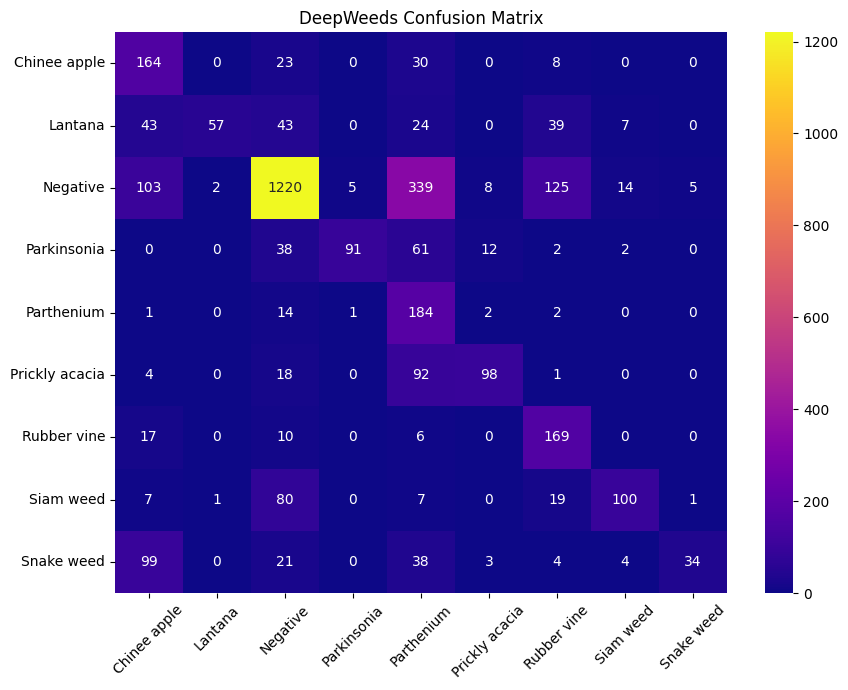

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("DeepWeeds Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
